<a href="https://colab.research.google.com/github/sujalarora19/AI_Generated_Text_Detection/blob/main/LargeDataModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [ ]:
df_data = pd.read_csv('Dataset.csv')
df=df_data.copy()
df.drop_duplicates(subset='domain',inplace=True)
df.rename(columns={'price':'currbid'},inplace=True)
df.drop(axis=1, columns=['priority_score'], inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785962 entries, 0 to 785961
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   domain                            785962 non-null  object 
 1   category                          785962 non-null  object 
 2   words                             785962 non-null  object 
 3   suffix                            785962 non-null  object 
 4   whois_registrar                   785962 non-null  object 
 5   extensions_taken                  785962 non-null  int64  
 6   search_ad_competition_broad_term  785962 non-null  int64  
 7   search_ad_competition_exact_term  785962 non-null  int64  
 8   search_cpc_broad_term             785962 non-null  float64
 9   search_cpc_exact_term             785962 non-null  float64
 10  search_results_sld                785962 non-null  int64  
 11  search_results_term               785962 non-null  i

All are non-null \
No imputer needed

In [ ]:
index_cols = ['domain',"currbid"]
df["log_currbid"] = np.log1p(df["currbid"])  # log(1 + x) avoids log(0)
target_col = 'log_currbid'

In [ ]:
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in index_cols]
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove(target_col)
for i in index_cols:
  if i in numerical_cols:
    numerical_cols.remove(i)

# df[categorical_cols] = df[categorical_cols].fillna('<unk>')

In [ ]:
X = df[numerical_cols + categorical_cols]

y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])


# num_imputer = SimpleImputer(strategy='mean')
# X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
# X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])


scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [ ]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'eval_metric': ['rmse','mae']
}

evals_result = {}
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=False
)

train_rmse = evals_result['train']['rmse']
test_rmse = evals_result['test']['rmse']

train_mae = evals_result['train']['mae']
test_mae = evals_result['test']['mae']

# print(f"Final Train RMSE: {train_rmse[-1]}")
# print(f"Final Validation RMSE: {test_rmse[-1]}")
# print(f"Final Train MAE: {train_mae[-1]}")
# print(f"Final Validation MAE: {test_mae[-1]}")


## Since I am using the log method to avoid any -ve prediction, I need to calculate the mae rmse manually


--- Final Evaluation in Original Scale (exp(log_preds)) ---
Real RMSE: 243.12
Real MAE: 25.03


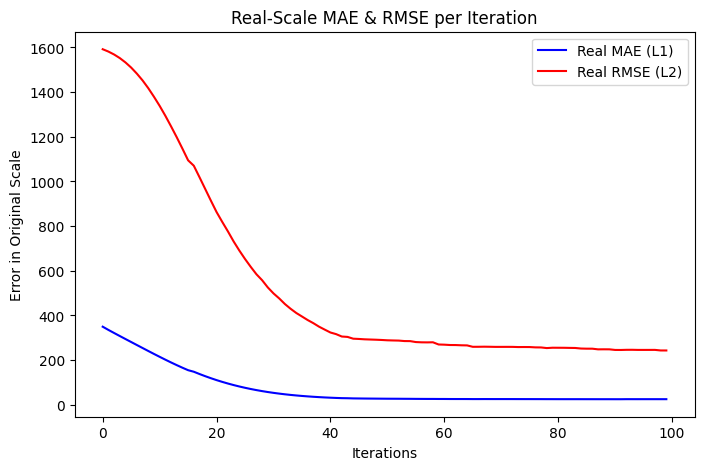

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on test set (log scale)
log_preds = xgb_model.predict(dtest)

# Convert predictions and true labels back to original scale
preds_actual = np.expm1(log_preds)
true_actual = np.expm1(y_test.values)  # since you log1p'd y, reverse it too

# Compute real-world metrics
real_rmse = np.sqrt(mean_squared_error(true_actual, preds_actual))
real_mae = mean_absolute_error(true_actual, preds_actual)

print("\n--- Final Evaluation in Original Scale (exp(log_preds)) ---")
print(f"Real RMSE: {real_rmse:.2f}")
print(f"Real MAE: {real_mae:.2f}")

real_rmse_per_round = []
real_mae_per_round = []

for i in range(1, len(train_rmse) + 1):
    preds_log = xgb_model.predict(dtest, iteration_range=(0, i))
    preds_actual = np.expm1(preds_log)
    true_actual = np.expm1(y_test.values)

    rmse = np.sqrt(mean_squared_error(true_actual, preds_actual))
    mae = mean_absolute_error(true_actual, preds_actual)

    real_rmse_per_round.append(rmse)
    real_mae_per_round.append(mae)
plt.figure(figsize=(8, 5))
plt.plot(real_mae_per_round, label="Real MAE (L1)", color='blue')
plt.plot(real_rmse_per_round, label="Real RMSE (L2)", color='red')
plt.xlabel("Iterations")
plt.ylabel("Error in Original Scale")
plt.title("Real-Scale MAE & RMSE per Iteration")
plt.legend()
plt.show()
